### Trying out the Watershed Algorithm
[OpenCV Docs](https://docs.opencv.org/4.x/d3/db4/tutorial_py_watershed.html)

[Explanation](https://people.cmm.minesparis.psl.eu/users/beucher/wtshed.html)

[Helpful 3D Plotting Tutorial](https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html)

- Any greytone image can be considered as a topographic surface. 
- If we flood this surface from its minima and, if we prevent the merging of the waters coming from different sources, we partition the image into two different sets: the catchment basins and the watershed lines.
- If we apply this transformation to the image gradient, the catchment basins should theoretically correspond to the homogeneous grey level regions of this image. 

- gradient map
- binarization and distance map
- watershed
- top map

In [1]:
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits import mplot3d

#### Import image
- import
- downsize
- grayscale
- crop

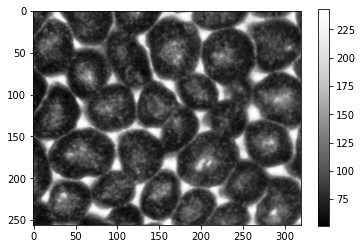

In [2]:
source_dir = "/Users/johnmays/Documents/Wirth Lab/convection-cell-research/data/LCB6mil90deg0_frames"
os.chdir(source_dir)
frame1 = cv.imread('frame1.png')
height, width, depth = np.shape(frame1)
frame1_downsized = cv.resize(frame1, (int(width/2), int(height/2)), cv.INTER_AREA) # downsize
frame1_downsized_gray = cv.cvtColor(frame1_downsized,cv.COLOR_BGR2GRAY)
frame1_cropped = frame1_downsized_gray[0:256,0:320]
plt.imshow(frame1_cropped, cmap='Greys_r')
plt.colorbar();

In [3]:
np.shape(frame1_cropped)

(256, 320)

In [4]:
frame1_upclose = frame1[50:250,50:250,0]
frame1_upclose = cv.medianBlur(frame1_upclose, 5)

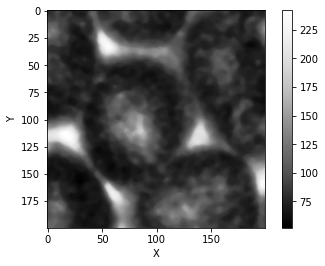

In [5]:
plt.imshow(frame1_upclose, cmap='Greys_r')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar();

In [6]:
x = np.arange(0,200)
y = np.arange(0,200)
X, Y = np.meshgrid(x, y)

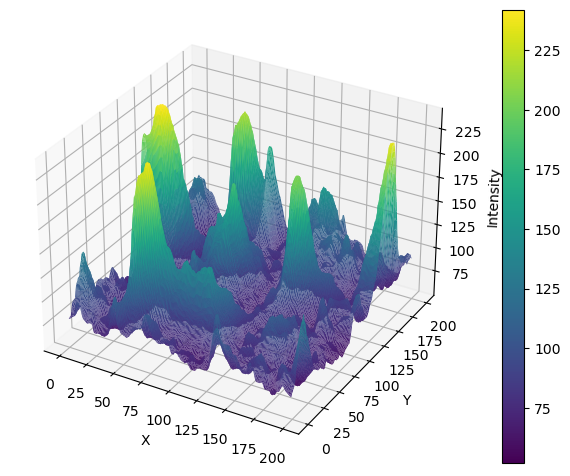

In [7]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')
p = ax.plot_surface(X, Y, frame1_upclose, rstride=1, cstride=1, cmap='viridis', edgecolor='none') #, cmap='Greys_r'
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(p, ax=ax)
ax.set_zlabel('Intensity');

Trying out a gradient map:

In [26]:
frame1_laplacian = cv.Laplacian(cv.medianBlur(cv.resize(frame1_upclose, (100, 100), cv.INTER_AREA), 5), cv.CV_64F)

In [27]:
frame1_sobel = cv.Sobel(cv.medianBlur(cv.resize(frame1_upclose, (100, 100), cv.INTER_AREA), 3), cv.CV_64F,1,1,ksize=5)

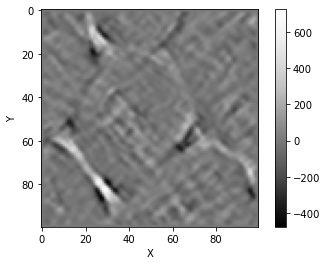

In [29]:
plt.imshow(frame1_sobel, cmap='Greys_r')
plt.xlabel('X')
plt.ylabel('Y')
plt.colorbar();

In [30]:
x = np.arange(0,100)
y = np.arange(0,100)
X, Y = np.meshgrid(x, y)

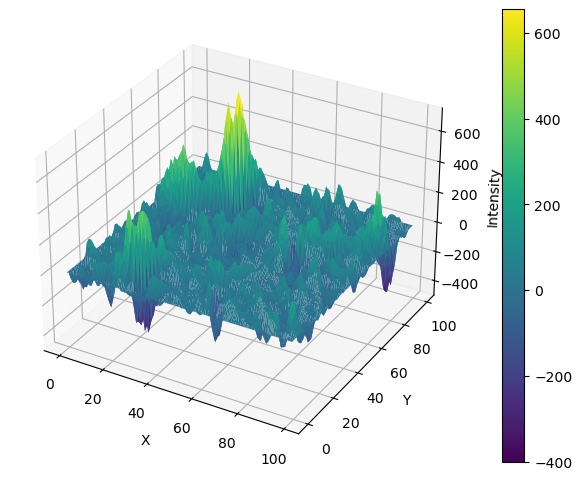

In [31]:
fig = plt.figure(figsize=(10,6), dpi=100)
ax = plt.axes(projection='3d')
p = ax.plot_surface(X, Y, frame1_sobel, rstride=1, cstride=1, cmap='viridis', edgecolor='none') #, cmap='Greys_r'
ax.set_xlabel('X')
ax.set_ylabel('Y')
fig.colorbar(p, ax=ax)
ax.set_zlabel('Intensity');

Not particularly helpful

#### Step 1: Preprocess
- binarize
- blur
- erode

In [13]:
ret, thresh = cv.threshold(frame1_cropped,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

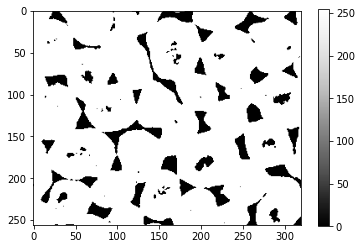

In [14]:
plt.imshow(thresh, cmap='Greys_r')
plt.colorbar();

In [15]:
# blur
kernel = np.ones((3,3),np.uint8)
opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)

In [16]:
sure_background = cv.dilate(opening,kernel,iterations=3)

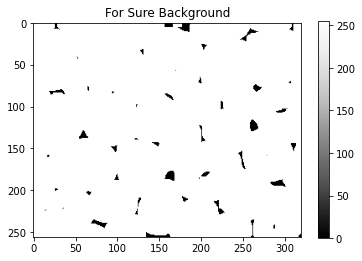

In [17]:
plt.imshow(sure_background, cmap='Greys_r')
plt.title("For Sure Background")
plt.colorbar();

In [18]:
distance_transform = cv.distanceTransform(opening,cv.DIST_L2,5)

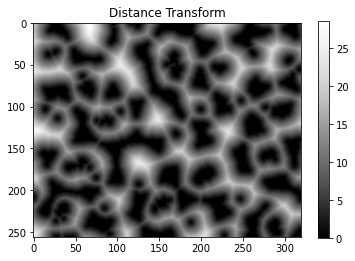

In [19]:
plt.imshow(distance_transform, cmap='Greys_r')
plt.title("Distance Transform")
plt.colorbar();

In [20]:
ret, sure_foreground = cv.threshold(distance_transform,0.65*distance_transform.max(),255,0)

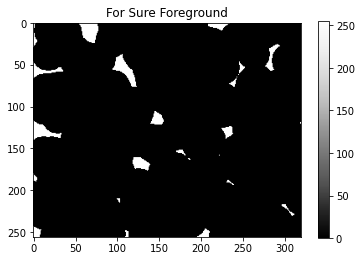

In [21]:
plt.imshow(sure_foreground, cmap='Greys_r')
plt.title("For Sure Foreground")
plt.colorbar();

In [22]:
sure_foreground = np.uint8(sure_foreground)
unknown = cv.subtract(sure_background,sure_foreground)

#### Step 2: Watershed

In [23]:
ret, markers = cv.connectedComponents(sure_foreground)
markers = markers+1
markers[unknown==255] = 0

In [24]:
frame1_3channel = np.stack((frame1_cropped,frame1_cropped,frame1_cropped), axis=-1) # (giving back RGB channels to greyscale image)
markers = cv.watershed(frame1_3channel, markers)
frame1_3channel[markers == -1] = [255,0,0]

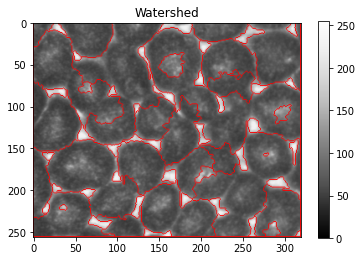

In [25]:
plt.imshow(frame1_3channel, cmap='Greys_r')
plt.title("Watershed")
plt.colorbar();

Downsides to Watershed:
- typically functions much better off of spawn regions, which is not a great idea for this data
- relies on the center of shapes being extrema